<a href="https://colab.research.google.com/github/kelgruber/bear-cnn-classification/blob/main/Kel_Gruber_Practice_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Practice Project Task 2 Build, Train and Evaluate Basic CNNs

Kel Gruber

## Dataset - Bears Classification
Goal is to classify images of grizzly, panda, and polar bears.
Dataset was created by Shaney Flores and consists of over 1000 digital colored images of grizzly, panda, and polar bears were downloaded from an Internet image search.
Dataset can be found and downloaded from [Shaney Flores's Github](https://github.com/shaneyflores/Classifying-Bear-Species-DL/blob/main/bears_ws.zip).

##1. Load Dataset
For reproducibility the dataset has been split before we begin into 3 sets, the training, validation and testing sets. The training set contains approximately 60% of the data, and the validation and testing sets each contain 20% of the data.

### Import libaries and connect to Drive

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Import Dataset from Drive and Unzip

In [ ]:
import zipfile
import os
zip_train = zipfile.ZipFile('/content/drive/MyDrive/Bears Classification/bears_ws.zip')
zip_train.extractall('/tmp')
zip_train.close()

###Import Training, Validation, and Testing Datasets

In [ ]:
image_generator = ImageDataGenerator(rescale=1./255)

training_data = image_generator.flow_from_directory( '/tmp/bears/training', target_size=(256, 256), batch_size=1, class_mode='categorical')
print(training_data.image_shape)

validation_set = image_generator.flow_from_directory( '/tmp/bears/validation', target_size=(256, 256), batch_size=1, class_mode='categorical')
print(validation_set.image_shape)

testing_set = image_generator.flow_from_directory( '/tmp/bears/test', target_size=(256, 256), batch_size=1, class_mode='categorical')
print(testing_set.image_shape)

Found 718 images belonging to 3 classes.
(256, 256, 3)
Found 240 images belonging to 3 classes.
(256, 256, 3)
Found 240 images belonging to 3 classes.
(256, 256, 3)


###View Some Examples from the Training Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

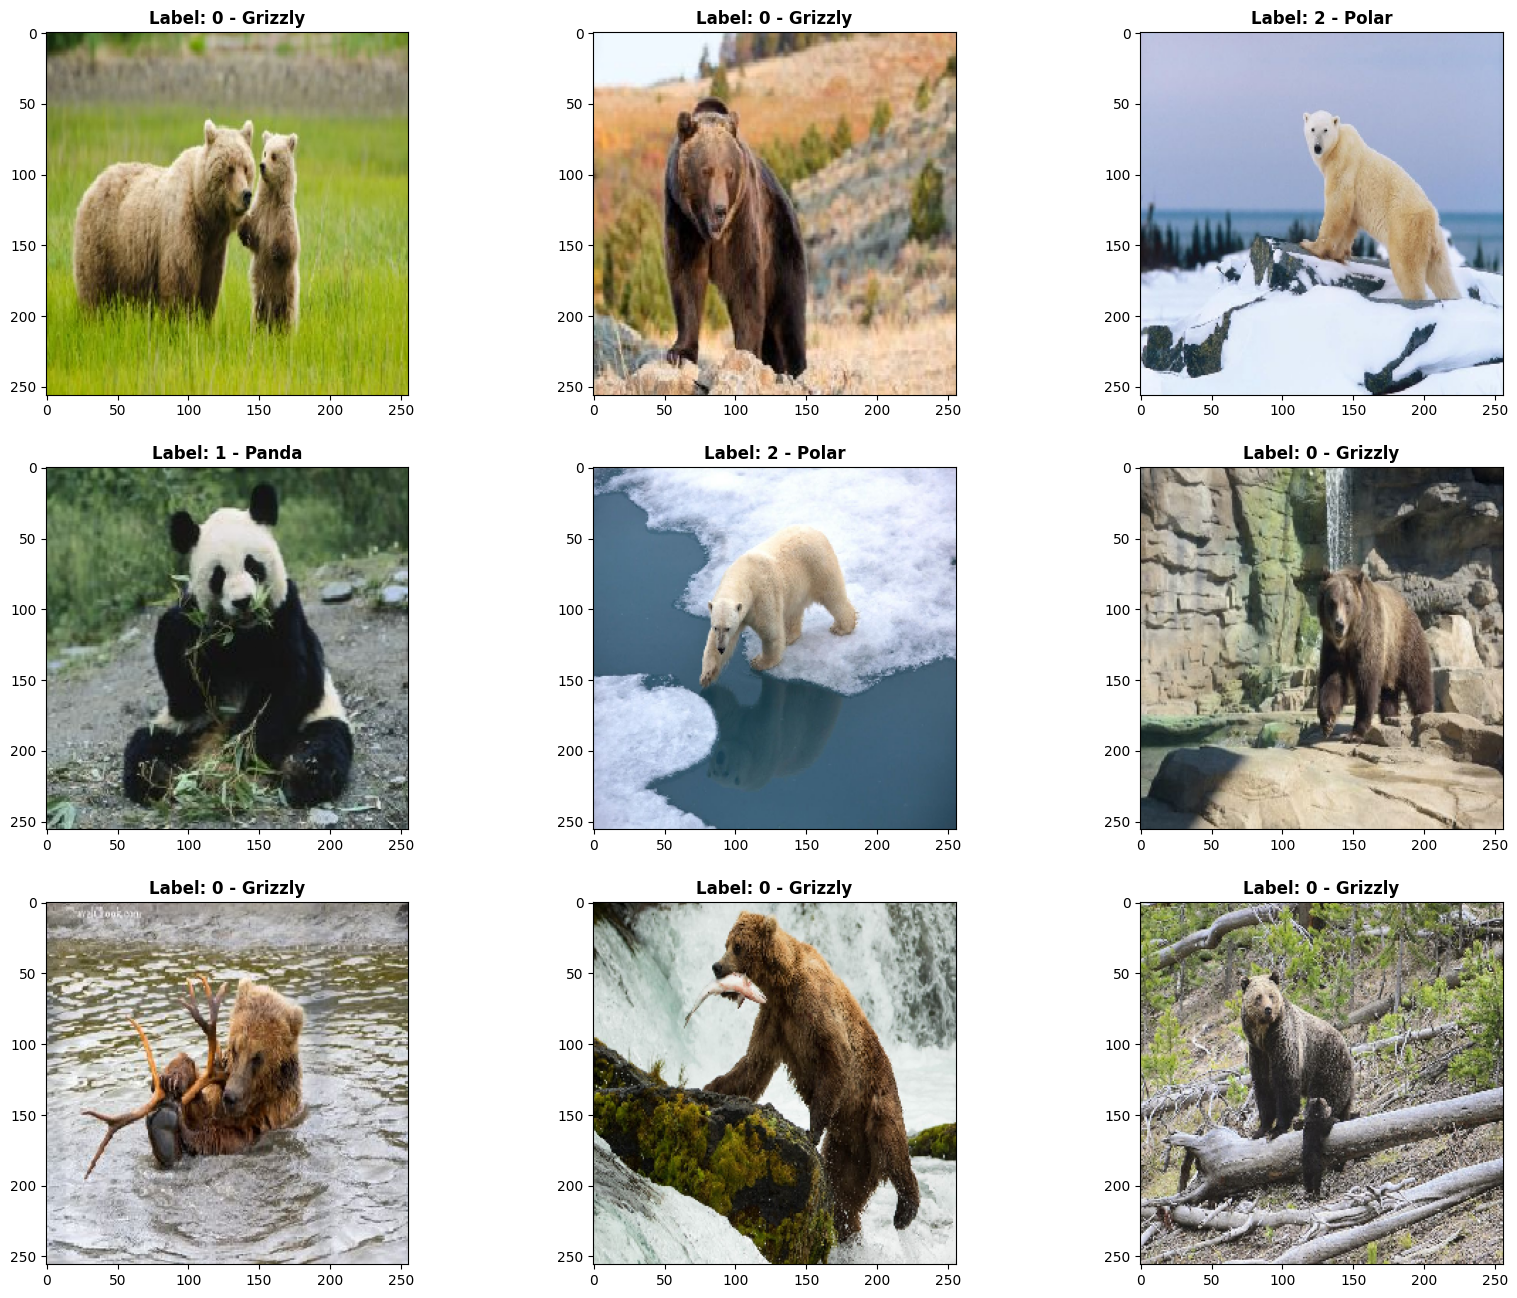

In [ ]:
label_category = {0: "Grizzly", 1: "Panda", 2: "Polar"}

images = []
labels = []
for i in range(9):
    image, label = next(training_data)
    images.append(image)
    labels.append(label)

labels = np.array(labels)
labels = np.squeeze(labels)
labels = np.argmax(labels, axis=1)
labels = list(labels)

# Plotting the images
plt.figure(figsize=(20,16))
for i in range(0,9):
    row = i // 3  # Calculate row index
    column = i % 3  # Calculate column index
    plt.subplot(3, 3, i + 1)
    plt.title(f'Label: {labels[i]} - {label_category[labels[i]]}',fontweight='bold')
    plt.imshow(images[i].squeeze())
plt.show()

##2. Build an Base Model

Our goal in this phase is to design and build a model that obtains highest possible accuracy on the validation set. We will be utilizing early stopping and model checkpointing to prevent overfitting and experimenting with tuning the hyperparameters.

###2.1 Basic Model 1

Model Structure:
- 3 Convolutional layers with 32, 64, and 64 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (2,2) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

We begin trying different CNN architectures by trying the suggested CNN structure in the task prompt. This model has 747,523 parameters which seems quite large considering how in Task 1 a model with only 24,000 parameters was capable of overfitting the data.

In [ ]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [ ]:
model_1 = Sequential()

model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add( Flatten() )
model_1.add( Dense(3, activation = 'softmax' ) )

model_1.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_141 (Conv2D)         (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_96 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_142 (Conv2D)         (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_97 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_143 (Conv2D)         (None, 60, 60, 64)        36928     
                                                                 
 flatten_23 (Flatten)        (None, 230400)          

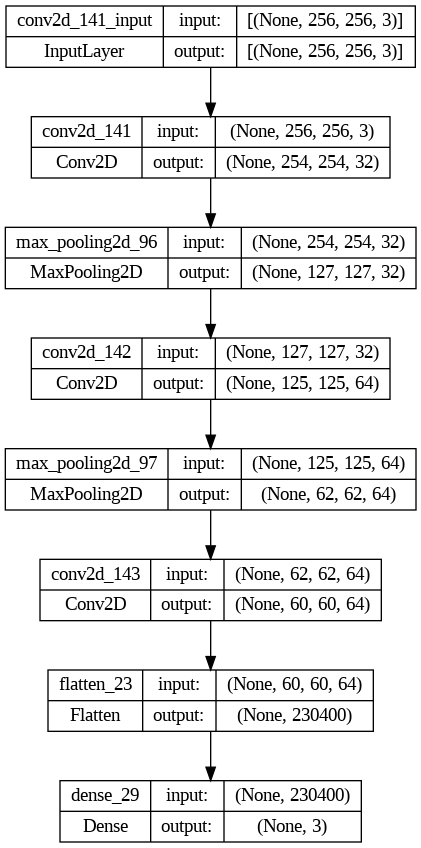

In [ ]:
tf.keras.utils.plot_model(model_1, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_1_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history1 = model_1.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
716/718 [============================>.] - ETA: 0s - loss: 1.0231 - accuracy: 0.5587
Epoch 1: val_loss improved from inf to 0.91655, saving model to model_1_best.hdf5
718/718 [==============================] - 7s 8ms/step - loss: 1.0232 - accuracy: 0.5585 - val_loss: 0.9166 - val_accuracy: 0.6333
Epoch 2/100
709/718 [============================>.] - ETA: 0s - loss: 0.8249 - accuracy: 0.6869
Epoch 2: val_loss improved from 0.91655 to 0.89661, saving model to model_1_best.hdf5
718/718 [==============================] - 7s 10ms/step - loss: 0.8193 - accuracy: 0.6908 - val_loss: 0.8966 - val_accuracy: 0.6792
Epoch 3/100
716/718 [============================>.] - ETA: 0s - loss: 0.5979 - accuracy: 0.8184
Epoch 3: val_loss did not improve from 0.89661
718/718 [==============================] - 6s 8ms/step - loss: 0.5963 - accuracy: 0.8189 - val_loss: 0.9440 - val_accuracy: 0.6458
Epoch 4/100
709/718 [============================>.] - ETA: 0s - loss: 0.3827 - accuracy: 0.9027
Epo

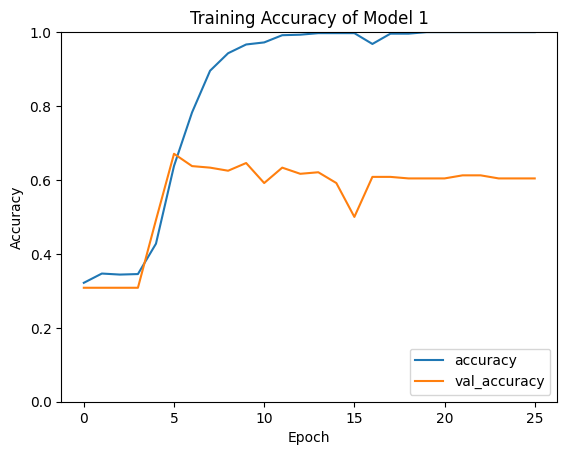

In [ ]:
plt.title('Training Accuracy of Model 1')
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

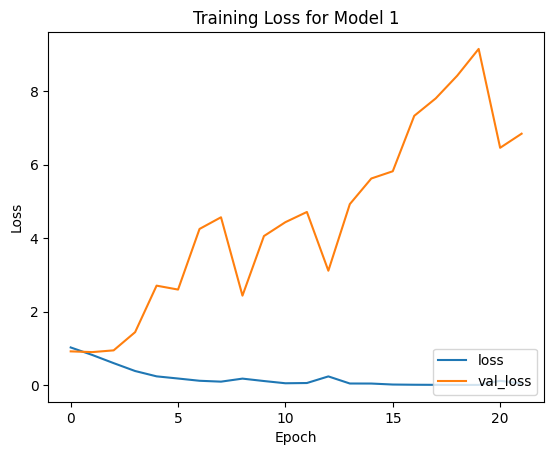

In [ ]:
plt.title('Training Loss for Model 1')
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_1.load_weights('model_1_best.hdf5')

from Prompt: In your report, you should discuss how the performance (accuracy, precision, recall, etc.) changes when the number of filters and layers are increased/decreased. Also, include your learning curves.

In [ ]:
val_loss, val_acc = model_1.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

240/240 [==============================] - 1s 5ms/step - loss: 0.8966 - accuracy: 0.6792
Accuracy: 67.91666746139526
Loss:0.8966130018234253


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_1.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6541666666666667
Precision: 0.6759553461178991
Recall: 0.6541666666666667
F1 Score: 0.6612141311445384


####Conclusion
Model 1 appears to have quickly overfit in just a few epochs meaning that it is probably too large of a CNN. Looking at the learning curves it is apparent that the validation loss only briefly decreases and then increases for the rest of training. The best saved model is only capable of 65.41% percent accuracy on the validation set so it performs better than the common sense baseline of 33.33% but I believe we can do better by changing the sizes of the convolutional layers and by reducing the total parameters in the network overall.  

###2.2 Model 2

Model Structure:
- 3 Convolutional layers with 64, 32 and 16 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (4,4) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

Looking at the learning curves its easy to see that the prior model very quickly overfit the data. I thought it might be best to try a smaller model. I looked back at my Task 1 report and decided to try one of the smaller models with the hope that with model checkpointing and early stopping that the model will not overfit too quickly.

In [ ]:
model_2 = Sequential()

model_2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_2.add(layers.MaxPooling2D((4, 4)))
model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((4, 4)))
model_2.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_2.add( Flatten() )
model_2.add( Dense(3, activation = 'softmax' ) )

model_2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 63, 63, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 61, 61, 32)        18464     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 13, 13, 16)        4624      
                                                                 
 flatten_7 (Flatten)         (None, 2704)            

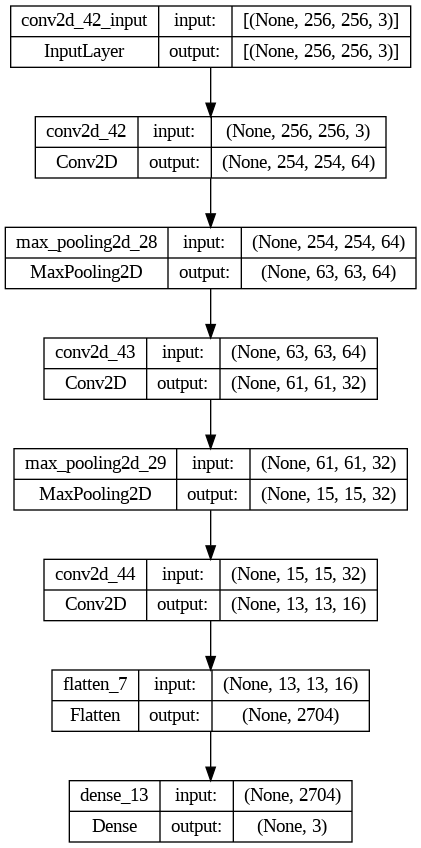

In [ ]:
tf.keras.utils.plot_model(model_2, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_2_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history2 = model_2.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
710/718 [============================>.] - ETA: 0s - loss: 0.8083 - accuracy: 0.6239
Epoch 1: val_loss improved from inf to 0.59798, saving model to model_2_best.hdf5
718/718 [==============================] - 7s 8ms/step - loss: 0.8157 - accuracy: 0.6226 - val_loss: 0.5980 - val_accuracy: 0.7542
Epoch 2/100
712/718 [============================>.] - ETA: 0s - loss: 0.5384 - accuracy: 0.7809
Epoch 2: val_loss improved from 0.59798 to 0.53133, saving model to model_2_best.hdf5
718/718 [==============================] - 8s 11ms/step - loss: 0.5367 - accuracy: 0.7813 - val_loss: 0.5313 - val_accuracy: 0.8042
Epoch 3/100
717/718 [============================>.] - ETA: 0s - loss: 0.3961 - accuracy: 0.8619
Epoch 3: val_loss improved from 0.53133 to 0.38730, saving model to model_2_best.hdf5
718/718 [==============================] - 6s 8ms/step - loss: 0.3974 - accuracy: 0.8607 - val_loss: 0.3873 - val_accuracy: 0.8417
Epoch 4/100
711/718 [============================>.] - ETA: 0

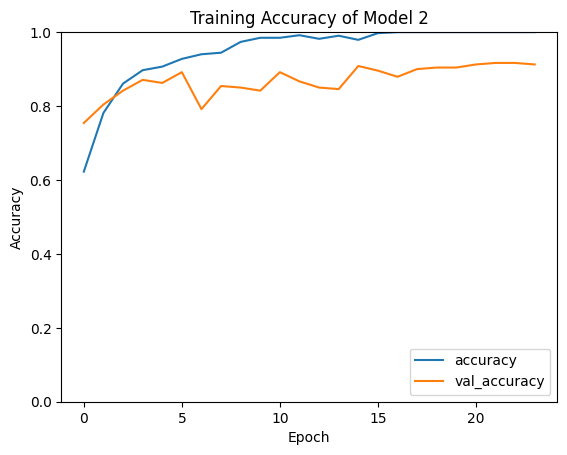

In [ ]:
plt.title('Training Accuracy of Model 2')
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

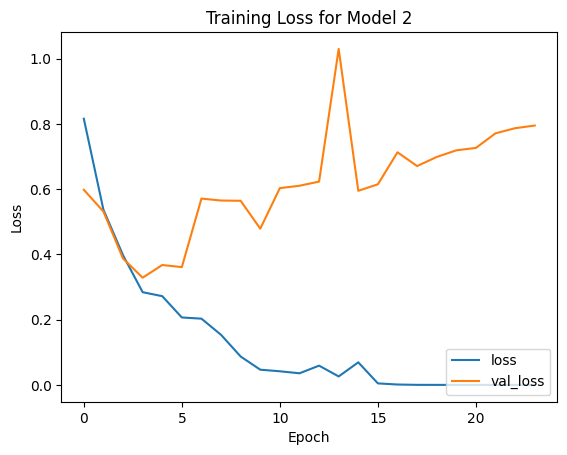

In [ ]:
plt.title('Training Loss for Model 2')
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_2.load_weights('model_2_best.hdf5')

In [ ]:
val_loss, val_acc = model_2.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

240/240 [==============================] - 1s 5ms/step - loss: 0.3285 - accuracy: 0.8708
Accuracy: 87.08333373069763
Loss:0.32854148745536804


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_2.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8708333333333333
Precision: 0.873919529521812
Recall: 0.8708333333333333
F1 Score: 0.8689374019043413


####Conclusion
Model 2 is a significant improvement over Model 1, with a 87.08% accuracy on the validation set. In this model I shifted the layers so that the convolutional layers decreased with each layer and I increased the max pooling window. By changing the layer order and max pooling size the total parameters in this model is significantly less than the initial suggested model. As shown in the learning curves it still does appear to begin to overfit during training, on the loss graph the validation loss appears to stop dropping around 3rd or 4th epoch but with model checkpointing we are able to reload a pretty good model.

###2.3 Model 3

Model Structure:
- 3 Convolutional layers with 64, 32 and 16 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (9,9) and (7,7) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

Model 2 did significantly better on the validation set but it is still overfitting, so I decided to try to reduce the parameters in the CNN more. I adjusted the max pooling layers to the max values I was able to try in Task 1 for this model.

In [ ]:
model_3 = Sequential()

model_3.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_3.add(layers.MaxPooling2D((9, 9)))
model_3.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((7, 7)))
model_3.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_3.add( Flatten() )
model_3.add( Dense(3, activation = 'softmax' ) )

model_3.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_144 (Conv2D)         (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_98 (MaxPooli  (None, 28, 28, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_145 (Conv2D)         (None, 26, 26, 32)        18464     
                                                                 
 max_pooling2d_99 (MaxPooli  (None, 3, 3, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_146 (Conv2D)         (None, 1, 1, 16)          4624      
                                                                 
 flatten_24 (Flatten)        (None, 16)              

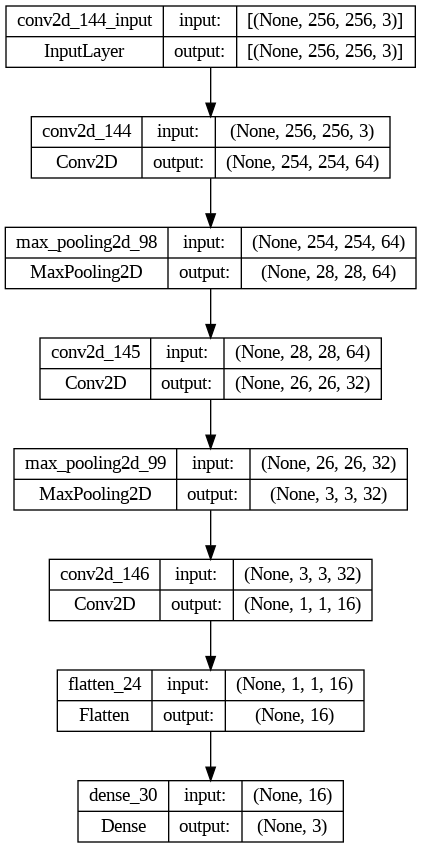

In [ ]:
tf.keras.utils.plot_model(model_3, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_3_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history3 = model_3.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
711/718 [============================>.] - ETA: 0s - loss: 0.9102 - accuracy: 0.5429
Epoch 1: val_loss improved from inf to 0.64498, saving model to model_3_best.hdf5
718/718 [==============================] - 7s 8ms/step - loss: 0.9083 - accuracy: 0.5460 - val_loss: 0.6450 - val_accuracy: 0.7042
Epoch 2/100
713/718 [============================>.] - ETA: 0s - loss: 0.4855 - accuracy: 0.8008
Epoch 2: val_loss did not improve from 0.64498
718/718 [==============================] - 10s 13ms/step - loss: 0.4918 - accuracy: 0.7981 - val_loss: 0.9003 - val_accuracy: 0.6542
Epoch 3/100
717/718 [============================>.] - ETA: 0s - loss: 0.4151 - accuracy: 0.8285
Epoch 3: val_loss improved from 0.64498 to 0.41518, saving model to model_3_best.hdf5
718/718 [==============================] - 7s 10ms/step - loss: 0.4146 - accuracy: 0.8287 - val_loss: 0.4152 - val_accuracy: 0.8417
Epoch 4/100
708/718 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8799
E

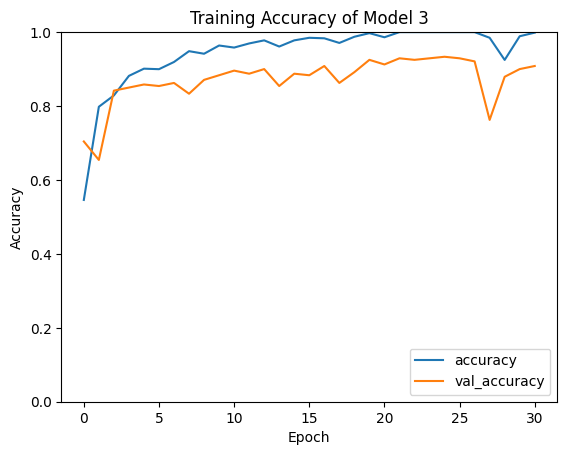

In [ ]:
plt.title('Training Accuracy of Model 3')
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

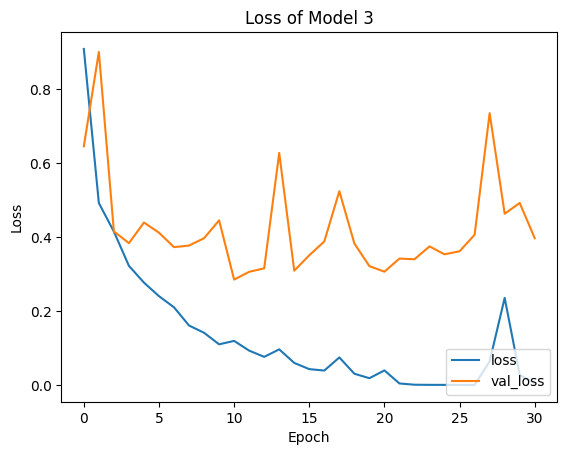

In [ ]:
plt.title('Training Loss for Model 3')
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_3.load_weights('model_3_best.hdf5')

In [ ]:
val_loss, val_acc = model_3.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

240/240 [==============================] - 1s 5ms/step - loss: 0.2849 - accuracy: 0.8958
Accuracy: 89.58333134651184
Loss:0.2848849296569824


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_3.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8833333333333333
Precision: 0.8864327605019094
Recall: 0.8833333333333333
F1 Score: 0.8829701043634367


####Conclusion
Model 3 was the best model so far with 88.33% percent accuracy on the validation set. It does appear to begin to overfit during training again around the 3rd or 4th epoch according to the learning curves, in particular the loss curve shows that the validation loss begin to increase but with model checkpointing we can reload the best model yet.

###2.4 Model 4 Model with 5 Convolutional Layers

Model Structure:
- 5 Convolutional layers with 64, 32, 32, 16, and 16 kernels, each using a relu activation function
- 4 MaxPool layers that follow the first, second, third and fourth convolutional layers with (2,2) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

 I am now adding more layers to the CNN so see if that improves accuracy at all. Prior models all used 3 convolution layers so in the this model I increased it to 5 layers to see if that improves or

In [ ]:
model_4 = Sequential()
model_4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_4.add( Flatten() )
model_4.add( Dense(3, activation = 'softmax' ) )

model_4.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_147 (Conv2D)         (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_100 (MaxPool  (None, 127, 127, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_148 (Conv2D)         (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_101 (MaxPool  (None, 62, 62, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_149 (Conv2D)         (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_102 (MaxPool  (None, 30, 30, 32)      

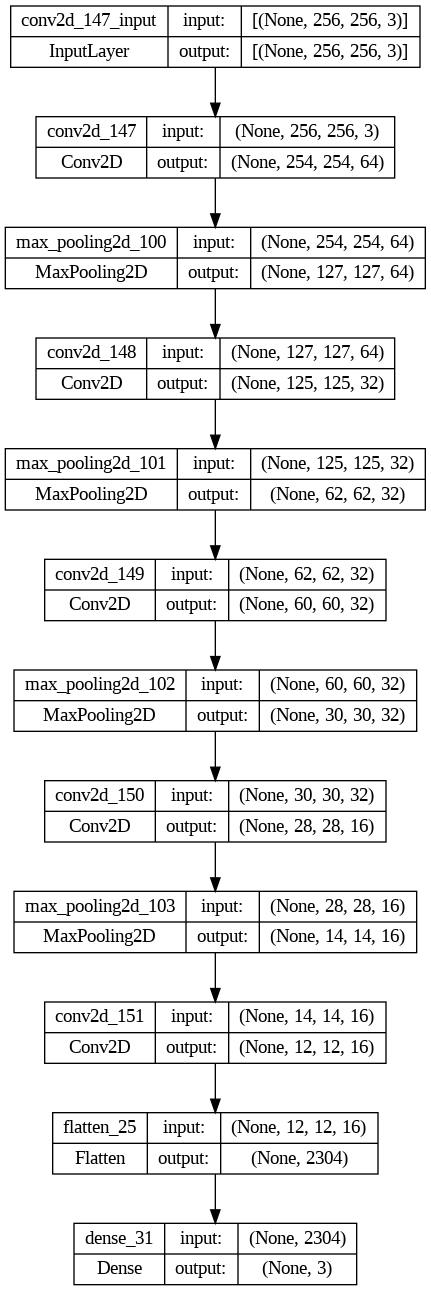

In [ ]:
tf.keras.utils.plot_model(model_4, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_4_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history4 = model_4.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
712/718 [============================>.] - ETA: 0s - loss: 1.0461 - accuracy: 0.4410
Epoch 1: val_loss improved from inf to 0.82026, saving model to model_4_best.hdf5
718/718 [==============================] - 9s 9ms/step - loss: 1.0412 - accuracy: 0.4443 - val_loss: 0.8203 - val_accuracy: 0.6792
Epoch 2/100
716/718 [============================>.] - ETA: 0s - loss: 0.6588 - accuracy: 0.7249
Epoch 2: val_loss improved from 0.82026 to 0.55861, saving model to model_4_best.hdf5
718/718 [==============================] - 8s 11ms/step - loss: 0.6596 - accuracy: 0.7242 - val_loss: 0.5586 - val_accuracy: 0.7750
Epoch 3/100
714/718 [============================>.] - ETA: 0s - loss: 0.4690 - accuracy: 0.8249
Epoch 3: val_loss improved from 0.55861 to 0.50257, saving model to model_4_best.hdf5
718/718 [==============================] - 8s 12ms/step - loss: 0.4672 - accuracy: 0.8259 - val_loss: 0.5026 - val_accuracy: 0.7833
Epoch 4/100
718/718 [==============================] - ETA: 

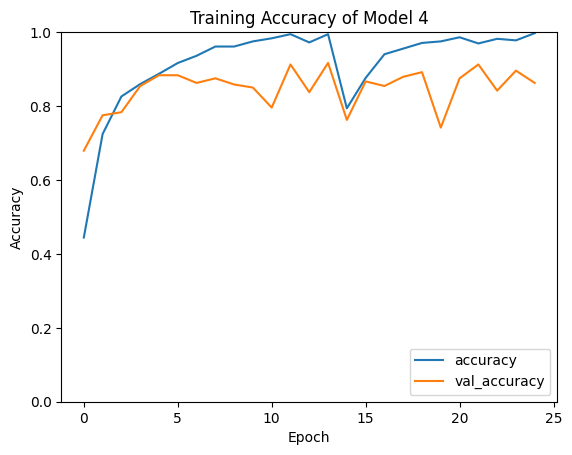

In [ ]:
plt.title('Training Accuracy of Model 4')
plt.plot(history4.history['accuracy'], label='accuracy')
plt.plot(history4.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

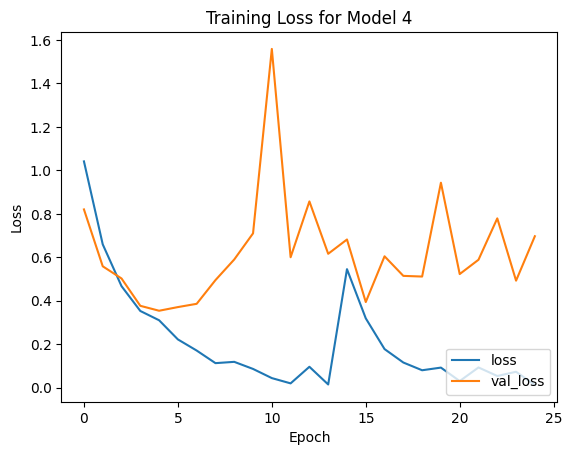

In [ ]:
plt.title('Training Loss for Model 4')
plt.plot(history4.history['loss'], label='loss')
plt.plot(history4.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_4.load_weights('model_4_best.hdf5')

In [ ]:
val_loss, val_acc = model_4.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

240/240 [==============================] - 1s 5ms/step - loss: 0.3542 - accuracy: 0.8833
Accuracy: 88.33333253860474
Loss:0.35415786504745483


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_4.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8916666666666667
Precision: 0.8918561854537462
Recall: 0.8916666666666667
F1 Score: 0.8916646036199594


####Conclusion
Model 4 manges to do slightly better than model 3 with a validation accuracy of 89.16%. It  was the best model so far with 88.33% percent accuracy on the validation set. It does appear to begin to overfit during training according to the learning curves, in particular the loss curve shows that the validation loss begin to increase but with model checkpointing we can reload the best model.

###2.5 Model 5 - Deep Model with 10 Convolutional Layers

Model Structure:
- 3 Convolutional layers with 64, 32 and 16 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (9,9) and (7,7) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

Model 2 did significantly better on the validation set but it is still overfitting, so I decided to try to reduce the parameters in the CNN more. I adjusted the max pooling layers to the max values I was able to try in Task 1 for this model.

In [ ]:
model_5 = Sequential()
model_5.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Conv2D(48, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_5.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_5.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_5.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_5.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Conv2D(8, (3, 3), activation='relu'))
model_5.add( Flatten() )
model_5.add( Dense(3, activation = 'softmax' ) )

model_5.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_152 (Conv2D)         (None, 254, 254, 64)      1792      
                                                                 
 conv2d_153 (Conv2D)         (None, 252, 252, 64)      36928     
                                                                 
 max_pooling2d_104 (MaxPool  (None, 126, 126, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_154 (Conv2D)         (None, 124, 124, 48)      27696     
                                                                 
 max_pooling2d_105 (MaxPool  (None, 62, 62, 48)        0         
 ing2D)                                                          
                                                                 
 conv2d_155 (Conv2D)         (None, 60, 60, 32)      

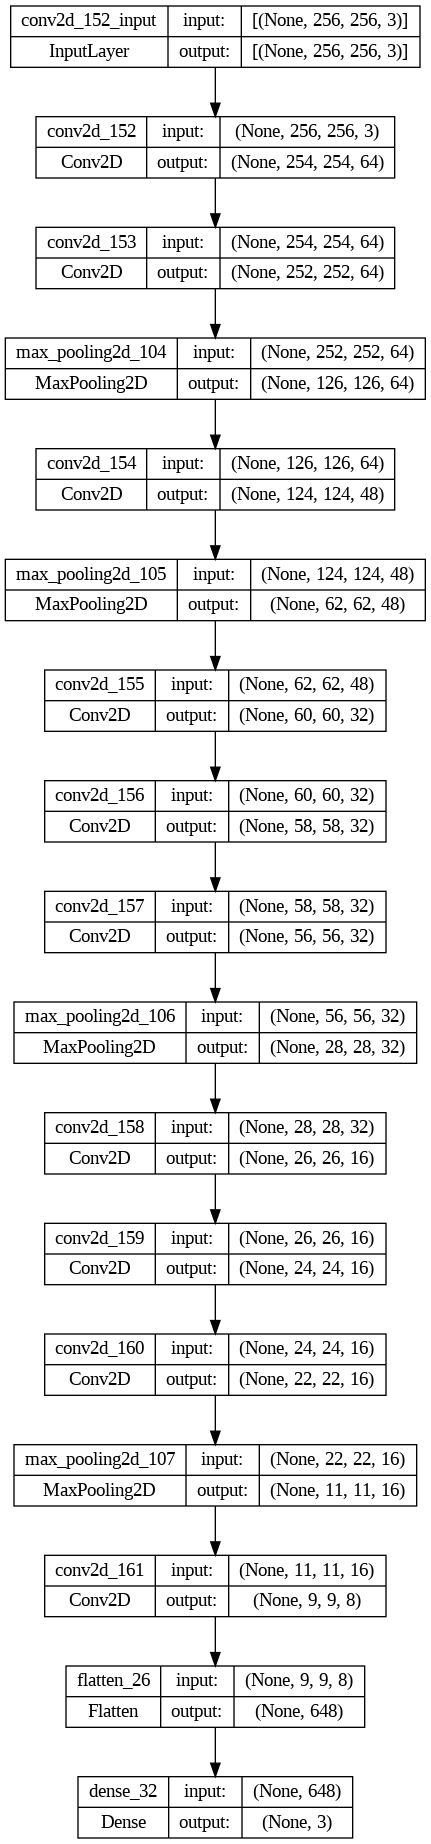

In [ ]:
tf.keras.utils.plot_model(model_5, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_5_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_5.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history5 = model_5.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
714/718 [============================>.] - ETA: 0s - loss: 1.0988 - accuracy: 0.3459
Epoch 1: val_loss improved from inf to 1.10110, saving model to model_5_best.hdf5
718/718 [==============================] - 13s 15ms/step - loss: 1.0989 - accuracy: 0.3454 - val_loss: 1.1011 - val_accuracy: 0.3083
Epoch 2/100
715/718 [============================>.] - ETA: 0s - loss: 1.0989 - accuracy: 0.3469
Epoch 2: val_loss improved from 1.10110 to 1.10104, saving model to model_5_best.hdf5
718/718 [==============================] - 11s 16ms/step - loss: 1.0989 - accuracy: 0.3454 - val_loss: 1.1010 - val_accuracy: 0.3083
Epoch 3/100
718/718 [==============================] - ETA: 0s - loss: 1.0989 - accuracy: 0.3454
Epoch 3: val_loss improved from 1.10104 to 1.10081, saving model to model_5_best.hdf5
718/718 [==============================] - 10s 14ms/step - loss: 1.0989 - accuracy: 0.3454 - val_loss: 1.1008 - val_accuracy: 0.3083
Epoch 4/100
717/718 [============================>.] - E

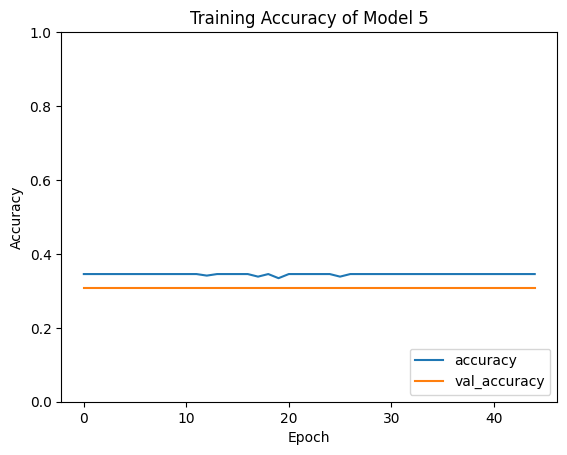

In [ ]:
plt.title('Training Accuracy of Model 5')
plt.plot(history5.history['accuracy'], label='accuracy')
plt.plot(history5.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

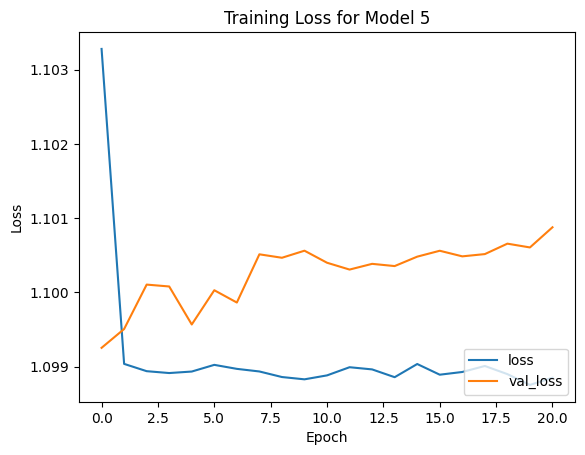

In [ ]:
plt.title('Training Loss for Model 5')
plt.plot(history5.history['loss'], label='loss')
plt.plot(history5.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_5.load_weights('model_5_best.hdf5')

In [ ]:
val_loss, val_acc = model_5.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

240/240 [==============================] - 1s 6ms/step - loss: 1.1000 - accuracy: 0.3083
Accuracy: 30.833333730697632
Loss:1.1000484228134155


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_5.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.3458333333333333
Precision: 0.11960069444444445
Recall: 0.3458333333333333
F1 Score: 0.17773477812177504


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####Conclusion
Model 5 struggled to learn as shown by the accuracy learning curves. It was too deep of a CNN with 10 convolutional layer and that has prevented it from learning. It barely beats a commonsense baseline of 33.33% (due to the 3 classes) with only a 34.5% accuracy on the validation set. There are techniques to assist deep CNN's train that might improve these results however in this problem using such a deep CNN does not make sense.

###2.6 Model 6 Using lots of Filters

Model Structure:
- 3 Convolutional layers with 200, 100, 50 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (9,9) and (7,7) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function



In [ ]:
model_6 = Sequential()
model_6.add(layers.Conv2D(200, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_6.add(layers.MaxPooling2D((9,9)))
model_6.add(layers.Conv2D(100, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((7, 7)))
model_6.add(layers.Conv2D(50, (3, 3), activation='relu'))
model_6.add( Flatten() )
model_6.add( Dense(3, activation = 'softmax' ) )

model_6.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_162 (Conv2D)         (None, 254, 254, 200)     5600      
                                                                 
 max_pooling2d_108 (MaxPool  (None, 28, 28, 200)       0         
 ing2D)                                                          
                                                                 
 conv2d_163 (Conv2D)         (None, 26, 26, 100)       180100    
                                                                 
 max_pooling2d_109 (MaxPool  (None, 3, 3, 100)         0         
 ing2D)                                                          
                                                                 
 conv2d_164 (Conv2D)         (None, 1, 1, 50)          45050     
                                                                 
 flatten_27 (Flatten)        (None, 50)              

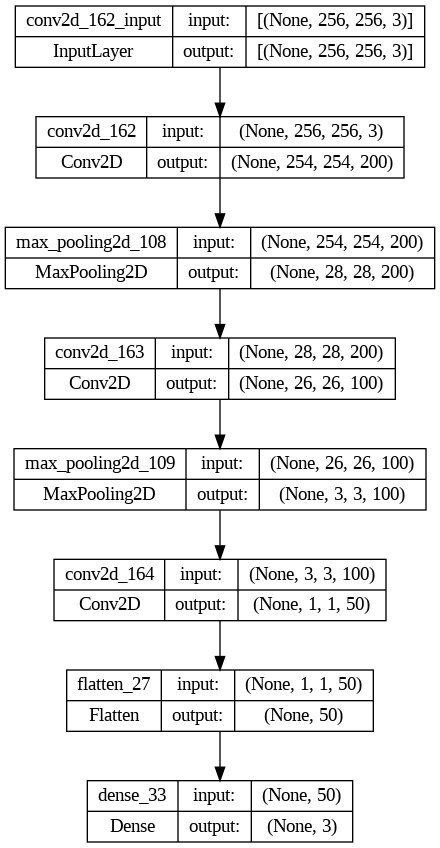

In [ ]:
tf.keras.utils.plot_model(model_6, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_6_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_6.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history6 = model_6.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
717/718 [============================>.] - ETA: 0s - loss: 0.8381 - accuracy: 0.5760
Epoch 1: val_loss improved from inf to 0.63503, saving model to model_6_best.hdf5
718/718 [==============================] - 9s 9ms/step - loss: 0.8371 - accuracy: 0.5766 - val_loss: 0.6350 - val_accuracy: 0.7292
Epoch 2/100
711/718 [============================>.] - ETA: 0s - loss: 0.5403 - accuracy: 0.8045
Epoch 2: val_loss improved from 0.63503 to 0.42836, saving model to model_6_best.hdf5
718/718 [==============================] - 9s 12ms/step - loss: 0.5375 - accuracy: 0.8050 - val_loss: 0.4284 - val_accuracy: 0.8333
Epoch 3/100
713/718 [============================>.] - ETA: 0s - loss: 0.4119 - accuracy: 0.8527
Epoch 3: val_loss improved from 0.42836 to 0.40510, saving model to model_6_best.hdf5
718/718 [==============================] - 6s 9ms/step - loss: 0.4126 - accuracy: 0.8510 - val_loss: 0.4051 - val_accuracy: 0.8667
Epoch 4/100
714/718 [============================>.] - ETA: 0

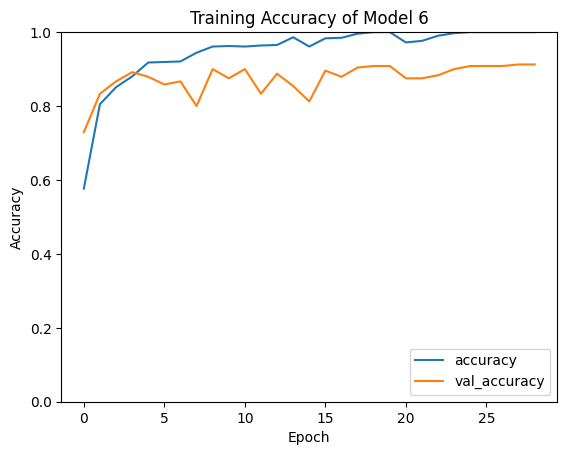

In [ ]:
plt.title('Training Accuracy of Model 6')
plt.plot(history6.history['accuracy'], label='accuracy')
plt.plot(history6.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

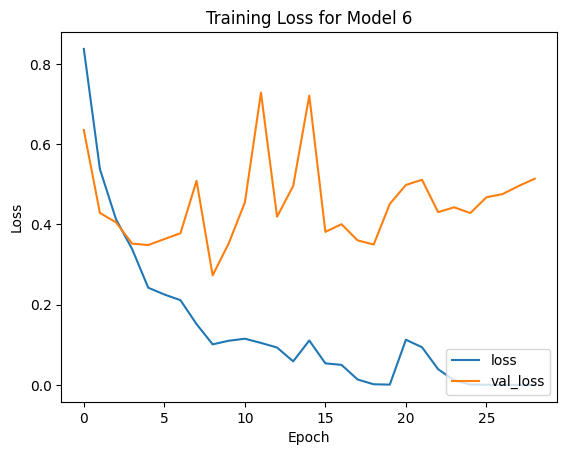

In [ ]:
plt.title('Training Loss for Model 6')
plt.plot(history6.history['loss'], label='loss')
plt.plot(history6.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_6.load_weights('model_6_best.hdf5')

In [ ]:
val_loss, val_acc = model_6.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

240/240 [==============================] - 1s 5ms/step - loss: 0.2729 - accuracy: 0.9000
Accuracy: 89.99999761581421
Loss:0.27293387055397034


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_6.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8958333333333334
Precision: 0.8971735099250343
Recall: 0.8958333333333334
F1 Score: 0.8960737187021264


####Conclusion
Model 6 while it is appling lots of filters it is not too deep to train unlike Model 5. In fact this model has performed the best on the validation set so far with 89.58% accuracy on the validation set. Looking at the learning curves it appears to have overfit pretty quickly however something interesting is that the validation accuracy and validation loss curves jump around a lot. I wonder if this is because there are so many parameters due to all of the filters. It seems that even though the model is only making small changes each epoch when so many parameters are adjusted a little it would make large changes to the model over all.

###2.7 Model 7 Only 1 Convolutional Layer

Model Structure:
- 1 Convolutional layers with 32 kernels using a relu activation function
- 1 MaxPool layers with (9,9) pooling windows
- 1 Flatten Layer after the convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

This experiment is to see what happens when you only have 1 convolutional layer in the CNN.

In [ ]:
model_7 = Sequential()
model_7.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_7.add(layers.MaxPooling2D((9,9)))
model_7.add( Flatten() )
model_7.add( Dense(3, activation = 'softmax' ) )

model_7.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_168 (Conv2D)         (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_112 (MaxPool  (None, 28, 28, 32)        0         
 ing2D)                                                          
                                                                 
 flatten_30 (Flatten)        (None, 25088)             0         
                                                                 
 dense_36 (Dense)            (None, 3)                 75267     
                                                                 
Total params: 76163 (297.51 KB)
Trainable params: 76163 (297.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


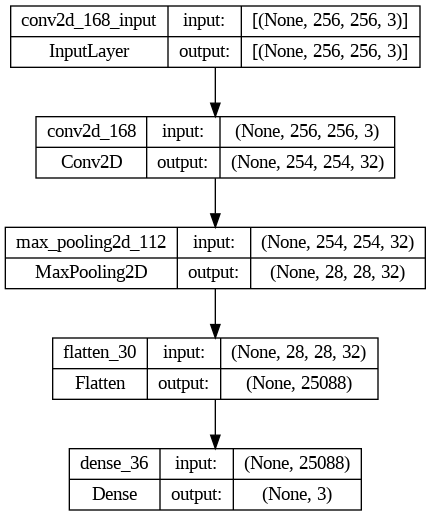

In [ ]:
tf.keras.utils.plot_model(model_7, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_7_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_7.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history7 = model_7.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
715/718 [============================>.] - ETA: 0s - loss: 0.8005 - accuracy: 0.6937
Epoch 1: val_loss improved from inf to 0.59614, saving model to model_7_best.hdf5
718/718 [==============================] - 12s 15ms/step - loss: 0.7985 - accuracy: 0.6950 - val_loss: 0.5961 - val_accuracy: 0.7583
Epoch 2/100
712/718 [============================>.] - ETA: 0s - loss: 0.3629 - accuracy: 0.8708
Epoch 2: val_loss improved from 0.59614 to 0.49952, saving model to model_7_best.hdf5
718/718 [==============================] - 8s 11ms/step - loss: 0.3614 - accuracy: 0.8719 - val_loss: 0.4995 - val_accuracy: 0.8375
Epoch 3/100
717/718 [============================>.] - ETA: 0s - loss: 0.2312 - accuracy: 0.9107
Epoch 3: val_loss improved from 0.49952 to 0.48426, saving model to model_7_best.hdf5
718/718 [==============================] - 9s 13ms/step - loss: 0.2350 - accuracy: 0.9095 - val_loss: 0.4843 - val_accuracy: 0.8250
Epoch 4/100
713/718 [============================>.] - ETA

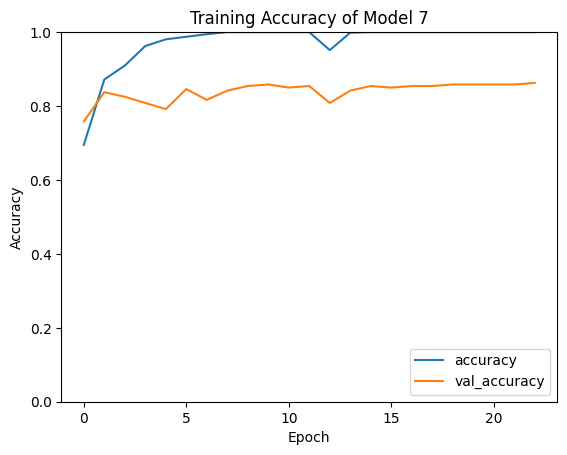

In [ ]:
plt.title('Training Accuracy of Model 7')
plt.plot(history7.history['accuracy'], label='accuracy')
plt.plot(history7.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

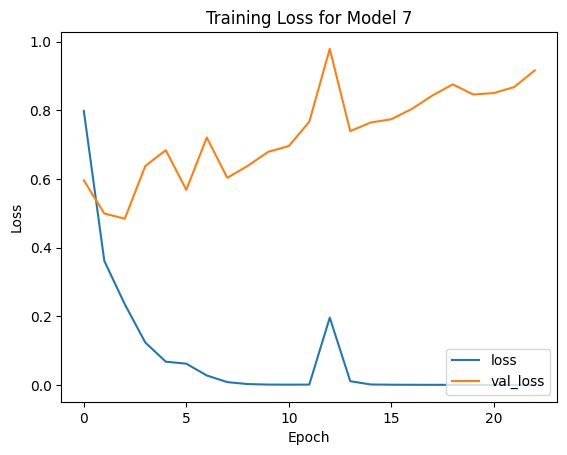

In [ ]:
plt.title('Training Loss for Model 7')
plt.plot(history7.history['loss'], label='loss')
plt.plot(history7.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_7.load_weights('model_7_best.hdf5')

In [ ]:
val_loss, val_acc = model_7.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

240/240 [==============================] - 2s 6ms/step - loss: 0.4843 - accuracy: 0.8250
Accuracy: 82.4999988079071
Loss:0.48425590991973877


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_7.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.825
Precision: 0.82881354470951
Recall: 0.825
F1 Score: 0.8249369279198245


####Conclusion
Model 7 is a very shallow CNN with only one convolutional layer, one maxpooling layer, on flatten layer, and one dense layer. According to the learning curves it quickly memorizes the data and overfits after just a few epochs, but with the model checkpointing it produces an ok model that has 82.5% accuracy on the validation set.

### 2.8 Model 8 Only 1 Convolutional Filter
Model Structure:
- 1 Convolutional layers with 1 kernel using a relu activation function
- 1 MaxPool layers with (9,9) pooling window
- 1 Flatten Layer after the convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

This model is built using only 1 convolutional layer and 1 filter to see what happens when you build a model with not enough filters.

In [ ]:
model_8 = Sequential()
model_8.add(layers.Conv2D(1, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_8.add(layers.MaxPooling2D((9,9)))
model_8.add(Flatten() )
model_8.add(Dense(3, activation = 'softmax' ) )

model_8.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_170 (Conv2D)         (None, 254, 254, 1)       28        
                                                                 
 max_pooling2d_114 (MaxPool  (None, 28, 28, 1)         0         
 ing2D)                                                          
                                                                 
 flatten_32 (Flatten)        (None, 784)               0         
                                                                 
 dense_38 (Dense)            (None, 3)                 2355      
                                                                 
Total params: 2383 (9.31 KB)
Trainable params: 2383 (9.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


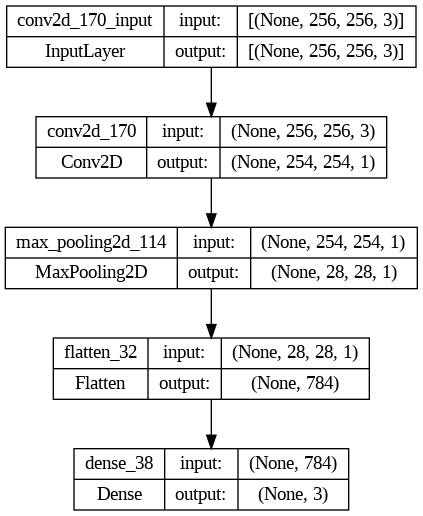

In [ ]:
tf.keras.utils.plot_model(model_8, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_8_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_8.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history8 = model_8.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
712/718 [============================>.] - ETA: 0s - loss: 1.1150 - accuracy: 0.3989
Epoch 1: val_loss improved from inf to 1.07963, saving model to model_8_best.hdf5
718/718 [==============================] - 12s 14ms/step - loss: 1.1139 - accuracy: 0.3997 - val_loss: 1.0796 - val_accuracy: 0.3958
Epoch 2/100
715/718 [============================>.] - ETA: 0s - loss: 0.9436 - accuracy: 0.5664
Epoch 2: val_loss improved from 1.07963 to 0.91885, saving model to model_8_best.hdf5
718/718 [==============================] - 9s 13ms/step - loss: 0.9434 - accuracy: 0.5655 - val_loss: 0.9189 - val_accuracy: 0.5708
Epoch 3/100
716/718 [============================>.] - ETA: 0s - loss: 0.8197 - accuracy: 0.6453
Epoch 3: val_loss did not improve from 0.91885
718/718 [==============================] - 12s 16ms/step - loss: 0.8203 - accuracy: 0.6448 - val_loss: 0.9368 - val_accuracy: 0.5792
Epoch 4/100
707/718 [============================>.] - ETA: 0s - loss: 0.7691 - accuracy: 0.6803

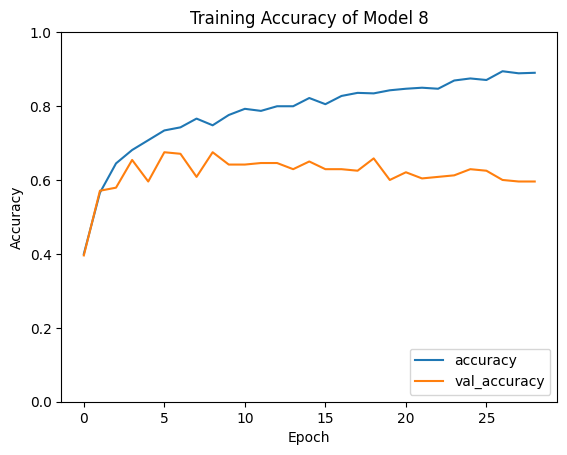

In [ ]:
plt.title('Training Accuracy of Model 8')
plt.plot(history8.history['accuracy'], label='accuracy')
plt.plot(history8.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

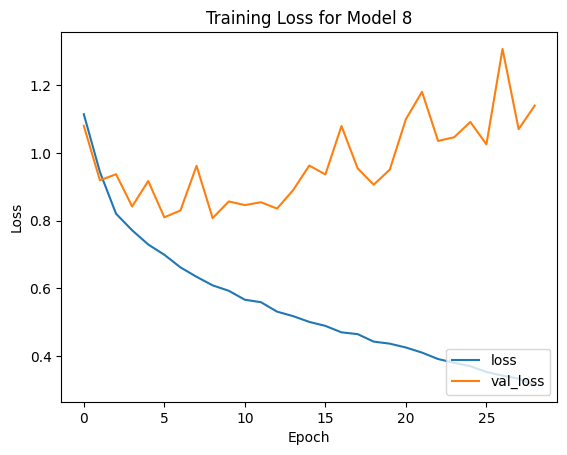

In [ ]:
plt.title('Training Loss for Model 8')
plt.plot(history8.history['loss'], label='loss')
plt.plot(history8.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_8.load_weights('model_8_best.hdf5')

In [ ]:
val_loss, val_acc = model_8.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

240/240 [==============================] - 1s 5ms/step - loss: 0.8073 - accuracy: 0.6750
Accuracy: 67.5000011920929
Loss:0.8072649240493774


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_8.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.675
Precision: 0.6748390170182008
Recall: 0.675
F1 Score: 0.6746933648007474


####Conclusion
Model 8 is another shallow CNN with only one convolutional layer that only has 1 convolution filter, one maxpooling layer, on flatten layer, and one dense layer. According to the learning curves it quickly memorizes the data and overfits after just a few epochs but even then with the model checkpointing it produces an ok model that has 82.5% accuracy on the validation set. It is not

### 2.9 Model 9 Reducing the Size of the Images
Model Structure:
- 3 Convolutional layers with 64, 32 and 16 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (2,2) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

This model is based off Model 3 but instead of taking 256x256 images it takes a 48x48 images as input.

In [ ]:
image_generator = ImageDataGenerator(rescale=1./255)

training_data_48 = image_generator.flow_from_directory( '/tmp/bears/training', target_size=(48, 48), batch_size=1, class_mode='categorical')
print(training_data_48.image_shape)

validation_set_48 = image_generator.flow_from_directory( '/tmp/bears/validation', target_size=(48, 48), batch_size=1, class_mode='categorical')
print(validation_set_48.image_shape)

testing_set_48 = image_generator.flow_from_directory( '/tmp/bears/test', target_size=(48, 48), batch_size=1, class_mode='categorical')
print(testing_set_48.image_shape)

Found 718 images belonging to 3 classes.
(48, 48, 3)
Found 240 images belonging to 3 classes.
(48, 48, 3)
Found 240 images belonging to 3 classes.
(48, 48, 3)


In [ ]:
model_9 = Sequential()

model_9.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=training_data_48.image_shape))
model_9.add(layers.MaxPooling2D((2, 2)))
model_9.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_9.add(layers.MaxPooling2D((2, 2)))
model_9.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_9.add( Flatten() )
model_9.add( Dense(3, activation = 'softmax' ) )

model_9.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_173 (Conv2D)         (None, 46, 46, 64)        1792      
                                                                 
 max_pooling2d_117 (MaxPool  (None, 23, 23, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_174 (Conv2D)         (None, 21, 21, 32)        18464     
                                                                 
 max_pooling2d_118 (MaxPool  (None, 10, 10, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_175 (Conv2D)         (None, 8, 8, 16)          4624      
                                                                 
 flatten_33 (Flatten)        (None, 1024)            

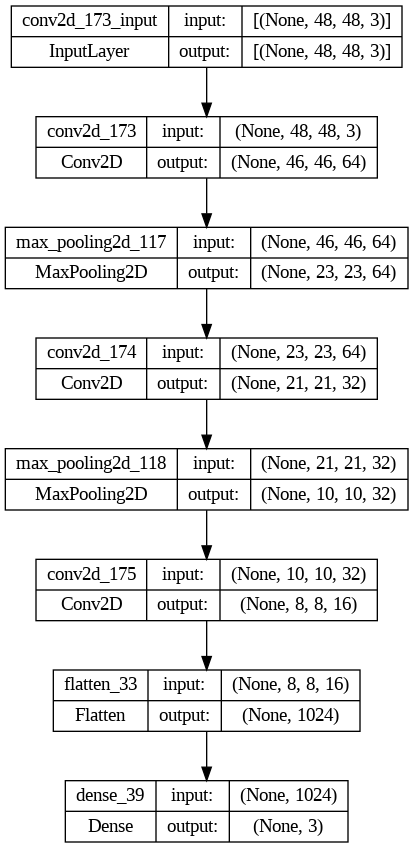

In [ ]:
tf.keras.utils.plot_model(model_9, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_9_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_9.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history9 = model_9.fit(training_data_48, validation_data = validation_set_48, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
708/718 [============================>.] - ETA: 0s - loss: 0.9547 - accuracy: 0.5085
Epoch 1: val_loss improved from inf to 0.66296, saving model to model_9_best.hdf5
718/718 [==============================] - 6s 7ms/step - loss: 0.9539 - accuracy: 0.5084 - val_loss: 0.6630 - val_accuracy: 0.7125
Epoch 2/100
714/718 [============================>.] - ETA: 0s - loss: 0.6198 - accuracy: 0.7325
Epoch 2: val_loss improved from 0.66296 to 0.56839, saving model to model_9_best.hdf5
718/718 [==============================] - 6s 9ms/step - loss: 0.6208 - accuracy: 0.7312 - val_loss: 0.5684 - val_accuracy: 0.7792
Epoch 3/100
706/718 [============================>.] - ETA: 0s - loss: 0.4751 - accuracy: 0.8017
Epoch 3: val_loss improved from 0.56839 to 0.54536, saving model to model_9_best.hdf5
718/718 [==============================] - 5s 7ms/step - loss: 0.4770 - accuracy: 0.8008 - val_loss: 0.5454 - val_accuracy: 0.7708
Epoch 4/100
709/718 [============================>.] - ETA: 0s

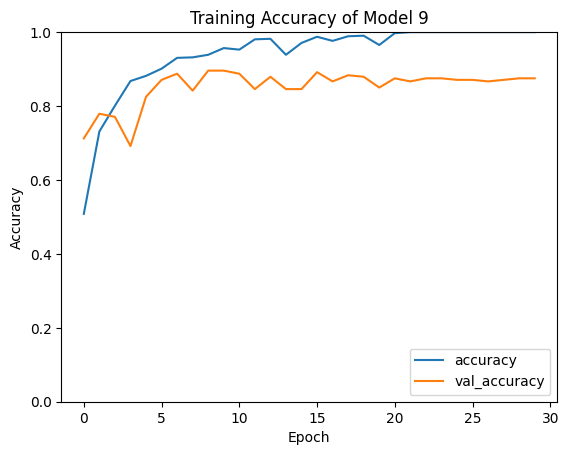

In [ ]:
plt.title('Training Accuracy of Model 9')
plt.plot(history9.history['accuracy'], label='accuracy')
plt.plot(history9.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

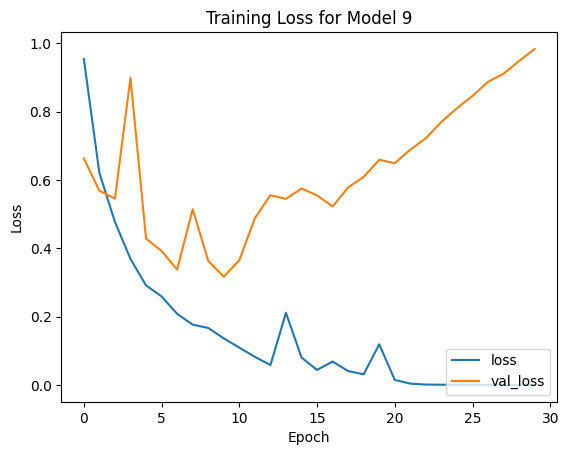

In [ ]:
plt.title('Training Loss for Model 9')
plt.plot(history9.history['loss'], label='loss')
plt.plot(history9.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_9.load_weights('model_9_best.hdf5')

In [ ]:
val_loss, val_acc = model_9.evaluate(validation_set_48)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

240/240 [==============================] - 1s 5ms/step - loss: 0.3166 - accuracy: 0.8958
Accuracy: 89.58333134651184
Loss:0.31663960218429565


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set_48)):
   x, y = validation_set_48.next()
   p = model_9.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8958333333333334
Precision: 0.9001570048309179
Recall: 0.8958333333333334
F1 Score: 0.8963853350950125


####Conclusion
This model surprised me, it trained incredibly fast and performed just as well as Model 3 which it was based on. I had thought that the model using smaller images would not perform as well and this model showed that this is an incorrect assumption.

##3. Evaluate Best Model on the Testing Dataset
Since Model 3, 4 and 6 all did pretty similarly on the validation set I decided to evaluate all of them on the independent testing set.

###3.1 Evaluation of Model 3 on the Testing Set
Model Structure:
- 3 Convolutional layers with 64, 32 and 16 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (9,9) and (7,7) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

In [ ]:
# Get predictions from model 3 on testing set
P = [] # empty list of predictions
Y_true = []
for i in range(len(testing_set)):
   x, y = testing_set.next()
   p = model_3.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9083333333333333
Precision: 0.9119881687242798
Recall: 0.9083333333333333
F1 Score: 0.9074740981392949


###3.2 Evaluation of Model 4 on the Testing Set
Model 4 Structure:
- 5 Convolutional layers with 64, 32, 32, 16, and 16 kernels, each using a relu activation function
- 4 MaxPool layers that follow the first, second, third and fourth convolutional layers with (2,2) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

In [ ]:
# Get predictions from model 3 on testing set
P = [] # empty list of predictions
Y_true = []
for i in range(len(testing_set)):
   x, y = testing_set.next()
   p = model_4.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8791666666666667
Precision: 0.882936507936508
Recall: 0.8791666666666667
F1 Score: 0.8797346803186822


###3.3 Evaluation of Model 6 on the Testing Set
Model 6 Structure:
- 3 Convolutional layers with 200, 100, 50 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (9,9) and (7,7) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

In [ ]:
# Get predictions from model 3 on testing set
P = [] # empty list of predictions
Y_true = []
for i in range(len(testing_set)):
   x, y = testing_set.next()
   p = model_6.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8833333333333333
Precision: 0.8860784627767921
Recall: 0.8833333333333333
F1 Score: 0.8832518264677186


#3.4 Testing Set Conclusion
Surprisingly Model 3 which did poorest on the validation set compared to Models 4 and 6 did the best on the testing set with an

##4. Conclusion on hyperparameters

**How do the prediction accuracy and training speed change if you:**

- **increase/decrease the epochs? (try 2 to 100)?**

  Reducing the epochs can help prevent overfitting in your model and leads to faster training times, but if you only train for a few epochs you run the risk of an underfit model that has not fully learned the data set. Looking at the learning curves of the 6 models I built, most needed at least 3-4 epochs to reach the best model, if we had stopped at 2 epochs the model would have not learned as many patterns as it could and would have performed poorly on the validation and testing sets. Too many epochs on the other hand can lead to overfitting a model very easily. A few of the models I tried in this phase were also tried in Task 1 and when given a 100 epochs most of the models I tried were capable of memorizing the training data. The model then struggled and did not perform as well on the validation data because it did not learn how to generalize.

- **increase/decrease the number of layers? One layer is two lines: Conv2D and
  MaxPooling2D. (try 1 to 10)?**

  If you increase the layers too much then the you run the risk of your network becoming too deep and stuggling to learn. In model 5, I tested a 10 layer deep model and it struggled to perform better than baseline on the training set and performed worse than baseline on the validation set. There are methods to improve learning in deep networks but in a smaller project like this one it did not make sense to build such a large network, especially when even the smaller networks were already capable of overfitting and memorizing the dataset. The training takes longer in the deeper networks as well because each epoch takes longer to complete since the input must move through a larger network with more calculations.
  When you decrease the layers the model trains faster because the model is smaller and does not perform as many calculations. The model also quickly memorizes the training data while struggling on the validation set, indicating that it overfits to the training data. The overal accuracy of this model is not bad, in Model 7 it had about 82.5% accuracy overall but this model is not the best you can make, and by adding just 2 layers you can achieve 90% accuracy on the validation set. However as shown by Model 8 the number of filters applied per layer can help the shallower networks perform better overall. When there is only one layer and only a few filters then the model underfits and cannot learn all of the patterns in the data it needs to make good predictions.

- **increase/decrease the number of convolutional filters in all of the Conv2D layers? (try 1 to 200)?**
Increasing the number of convolutional filters in the layer increases the number of parameters in the network and can slow down the model's training speed, however when you have a shallower CNN they also can help this shallow model perform better. When you have fewer filters the model trains faster but you also are not capturing as many patterns in the data and when used in shallower networks only a few filters and layers are not enough to learn the patterns in the data. Models 7 and 8 are examples of shallower networks and how using 32 filters vs 1 filter has a significant impact on the model's final results.


- **increase/decrease the image size? (try 32/32, 64/64, to 256/256)?**
Most models in this notebook used 256x256 images. I initially thought that by resizing the images too small I would potentially not get as accurate of results because the images would not have as much data. However Model 9 was built using a similar structure to Model 3, which was one of the best performing models built and in this case Model 9 performed as well as Model 3. Model 9 did train significantly faster than Model 3 and I had to reduce the size of the maxpooling layers in the model since otherwise the image became too small for the convolutional layers to work with but it over all performed the same as Model 3. So from this experiment I would expect that larger images take longer for the model to train with, while smaller images lead to it training faster. In addition while the smaller images potentially limit the size of the CNN and maxpooling layers the models trained on the smaller image size can still perform as well models trained on the larger images.   
